This notebook taks the CSV as an input. The CSV was obtained from the original Dataset containing all the reviews from the users for the apps on the store. I've applaied a simple pre-processing steps in order to obtain an homogeneous corpus to feed LDA. Once the model was trained I've used it to extract the Topic distribuition latent in every reveiw. The Topic distribuition represents my set of features on which I will train the classifier. This is a Multi-Class classification problem in which I have N possibile classes in which classify my samples and where every sample has a certain amount of features.

In [ ]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.metrics import classification_report
import numpy as np
import re
  
def strToList(dato):
  line = re.sub('[(,)]', '', dato).split(" ") 
  distribuzione=[]
  for x in range(1, 15):
   if(x%2)!=0:
    distribuzione.append(float(line[x]))
  return distribuzione  



First things first. Let's import the dataset and let's give a peak at the data.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FinalDataset.csv",error_bad_lines=False, sep=',')
data.head() # Shows me the first 5 rows of the data set

#effettuo il drop di tutte quelle righe appartenenti a categorie espresse in modo composto
data = data[data.category != 'Connectivity,Development']
data = data[data.category != 'Connectivity,Theming']
data = data[data.category != 'Internet,Phone & SMS']
data = data[data.category != 'Internet,Reading']
data = data[data.category != 'Internet,Security']
data = data[data.category != 'Multimedia,Graphics']
data = data[data.category != 'Multimedia,Theming']
data = data[data.category != 'Phone & SMS']
data = data[data.category != 'Phone & SMS,Internet']
data = data[data.category != 'Phone & SMS,Multimedia']
data = data[data.category != 'Phone & SMS,Security']
data = data[data.category != 'Reading,Multimedia']
data = data[data.category != 'Science & Education']
data = data[data.category != 'Science & Education,Time']
data = data[data.category != 'Security,Internet']
data = data[data.category != 'Sports & Health']
data = data[data.category != 'System,Time']
data = data[data.category != 'Time,Writing']
data = data[data.category != 'System,Development']
data = data[data.category != 'Money']
data = data[data.category != 'Time']
data = data[data.category != 'Writing']
data = data[data.category != 'Graphics']
data = data[data.category != 'Development']

#converto i nomi delle classi rimanenti label numeriche
mask = data.category =='Internet'
column_name = 'category'
data.loc[mask, column_name] = 0

mask = data.category =='Connectivity'
column_name = 'category'
data.loc[mask, column_name] = 1

mask = data.category =='Games'
column_name = 'category'
data.loc[mask, column_name] = 2

mask = data.category =='Multimedia'
column_name = 'category'
data.loc[mask, column_name] = 3

mask = data.category =='Navigation'
column_name = 'category'
data.loc[mask, column_name] = 4

mask = data.category =='Reading'
column_name = 'category'
data.loc[mask, column_name] = 5

mask = data.category =='Security'
column_name = 'category'
data.loc[mask, column_name] = 6

mask = data.category =='System'
column_name = 'category'
data.loc[mask, column_name] = 7

mask = data.category =='Theming'
column_name = 'category'
data.loc[mask, column_name] = 8


data.head()

,review,category,TopicDistribuition
97,Crippling power consumption The devs really ne...,0,"[(0, 0.020833334), (1, 0.5208332), (2, 0.02083..."
98,Unusable in large rooms No way to filter out j...,0,"[(0, 0.0625), (1, 0.0625), (2, 0.0625), (3, 0...."
99,is there a way to hide channel list when using...,0,"[(0, 0.03125), (1, 0.53114474), (2, 0.03125), ..."
100,+1 star for finally including auto-reconnect ...,0,"[(0, 0.008928572), (1, 0.232126), (2, 0.366071..."
101,Material design update very nice,0,"[(0, 0.3750001), (1, 0.041666668), (2, 0.04166..."


I don't need the 'Review' column anymore. I have to extract 'category' and 'TopicDistribuition' column. I start extracting 'TopicDistribuition' first since I need to convert each string into a probability distribuition. So I took the 'TopicDistribuitions' column and transfer it into a list called 'temp'. 'temp' is a list of strings where each string represent a probability distribuition. I need just the numbers, so I need to convert each string.

In [ ]:
temp=data.TopicDistribuition.tolist()
print("Converto la colonna Topic Distribuition in una lista")
print(temp[:5])

Converto la colonna Topic Distribuition in una lista
['[(0, 0.020833334), (1, 0.5208332), (2, 0.020833334), (3, 0.020833334), (4, 0.020833334), (5, 0.020833334), (6, 0.020833334), (7, 0.35416678)]', '[(0, 0.0625), (1, 0.0625), (2, 0.0625), (3, 0.0625), (4, 0.0625), (5, 0.5625), (6, 0.0625), (7, 0.0625)]', '[(0, 0.03125), (1, 0.53114474), (2, 0.03125), (3, 0.031355355), (4, 0.2812499), (5, 0.03125), (6, 0.03125), (7, 0.03125)]', '[(0, 0.008928572), (1, 0.232126), (2, 0.36607176), (3, 0.28570276), (4, 0.08035694), (5, 0.008928572), (6, 0.0089470735), (7, 0.008938288)]', '[(0, 0.3750001), (1, 0.041666668), (2, 0.041666668), (3, 0.3749999), (4, 0.041666668), (5, 0.041666668), (6, 0.041666668), (7, 0.041666668)]']


In order to convert each string into a proper list of floats I am using the 'strToList' function

In [ ]:
x = [strToList(x) for x in temp ]
print("Conversione di temp in una lista di distribuzioni di probabilità")
print(x[:10])

#ho aggiunto questa conversione perchè sospetto che il fatto di averlo avuto sottoforma di lista abbia inficiato l'accuratezza
x=np.array([np.array(xi) for xi in x])
print(type(x))

Conversione di temp in una lista di distribuzioni di probabilità
[[0.020833334, 0.5208332, 0.020833334, 0.020833334, 0.020833334, 0.020833334, 0.020833334], [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.5625, 0.0625], [0.03125, 0.53114474, 0.03125, 0.031355355, 0.2812499, 0.03125, 0.03125], [0.008928572, 0.232126, 0.36607176, 0.28570276, 0.08035694, 0.008928572, 0.0089470735], [0.3750001, 0.041666668, 0.041666668, 0.3749999, 0.041666668, 0.041666668, 0.041666668], [0.34375042, 0.17708302, 0.09375009, 0.010416666, 0.09374999, 0.010416666, 0.093749575], [0.5114528, 0.03126889, 0.031254027, 0.3010243, 0.03125, 0.03125, 0.03125], [0.28124994, 0.03125, 0.031261522, 0.03125, 0.53123856, 0.03125, 0.03125], [0.015625, 0.14062455, 0.26562533, 0.26562467, 0.015625, 0.015625, 0.14062524], [0.51040554, 0.01042255, 0.010420013, 0.010422617, 0.17707926, 0.09375002, 0.17708336]]
<class 'numpy.ndarray'>


I need to obtain the labels too in a separate vector. I do so by saving them into the vector called 'y'

In [ ]:
y = data.category.tolist()
print("print della lista y contenente le categorie")
y=np.array([np.array(xi) for xi in y])
print(type(y))
print(y)

print della lista y contenente le categorie
<class 'numpy.ndarray'>
[0 0 0 ... 5 5 5]


Here I wanted to make sure that I had the same number of labels as the number of the probability distribuitions

In [ ]:
print("numero di distribuzioni di probabilità: "+str(len(x)))
print("numero di label: "+str(len(y)))

numero di distribuzioni di probabilità: 253071
numero di label: 253071


That's a first attempt in creating a new cleaned version of the original Dataset where TopicDistribuitions column had not strings but actual vectors of floats

In [ ]:
#questo codice funziona quando x e y non sono di tipo ndarray, ma adesso che li ho convertiti in questo tipo
#la colonna TopicDistribuitions non me la da più correttamente, ma questo poco importa perchè non uso newDataFrame
#questo codice faceva soltanto parte di una mia congettura per capire come aumentare l'accuracy.
my_column_names=['Reviews','TopicDistribuitions']
newDataFrame=pd.DataFrame(columns=my_column_names)
newDataFrame['Reviews']=y
newDataFrame['TopicDistribuitions']=x
newDataFrame.head()

,Reviews,TopicDistribuitions
0,0,0.020833
1,0,0.062500
2,0,0.031250
3,0,0.008929
4,0,0.375000


I suspected that in order to train the model properly I had to explicitate each Topic as a feature in a separate column. That's why I created another DataSet from the previously DataSet

In [ ]:
my_column_names=['Topic0','Topic1','Topic2','Topic3','Topic4','Topic5','Topic6']
new_DataFrame=pd.DataFrame(x,columns=my_column_names)
new_DataFrame['Topic_Classified']=new_DataFrame.idxmax(axis=1)
new_DataFrame['Category']=y
new_DataFrame.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic_Classified,Category
0,0.020833,0.520833,0.020833,0.020833,0.020833,0.020833,0.020833,Topic1,0
1,0.062500,0.062500,0.062500,0.062500,0.062500,0.562500,0.062500,Topic5,0
2,0.031250,0.531145,0.031250,0.031355,0.281250,0.031250,0.031250,Topic1,0
3,0.008929,0.232126,0.366072,0.285703,0.080357,0.008929,0.008947,Topic2,0
4,0.375000,0.041667,0.041667,0.375000,0.041667,0.041667,0.041667,Topic0,0


Printing an histogram of Topic Distribuition across the dataset

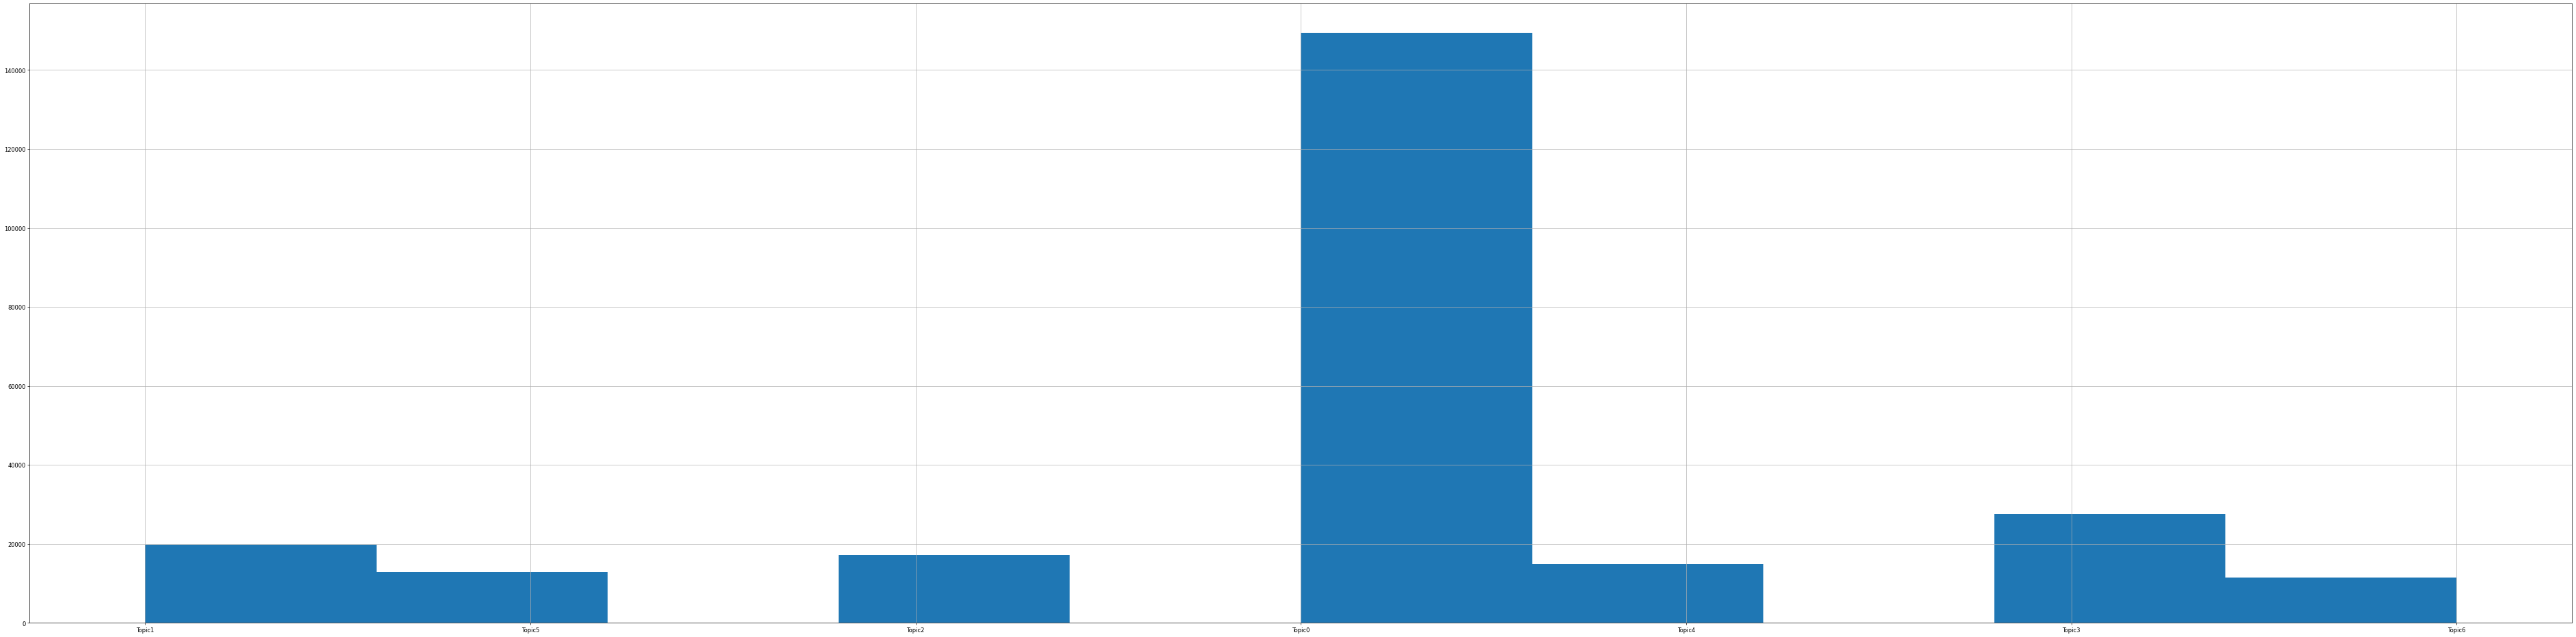

In [ ]:
plt.figure(figsize=(80, 20), dpi=60)
new_DataFrame['Topic_Classified'].hist()

Printing an histogram of Category Distribuition across the dataset

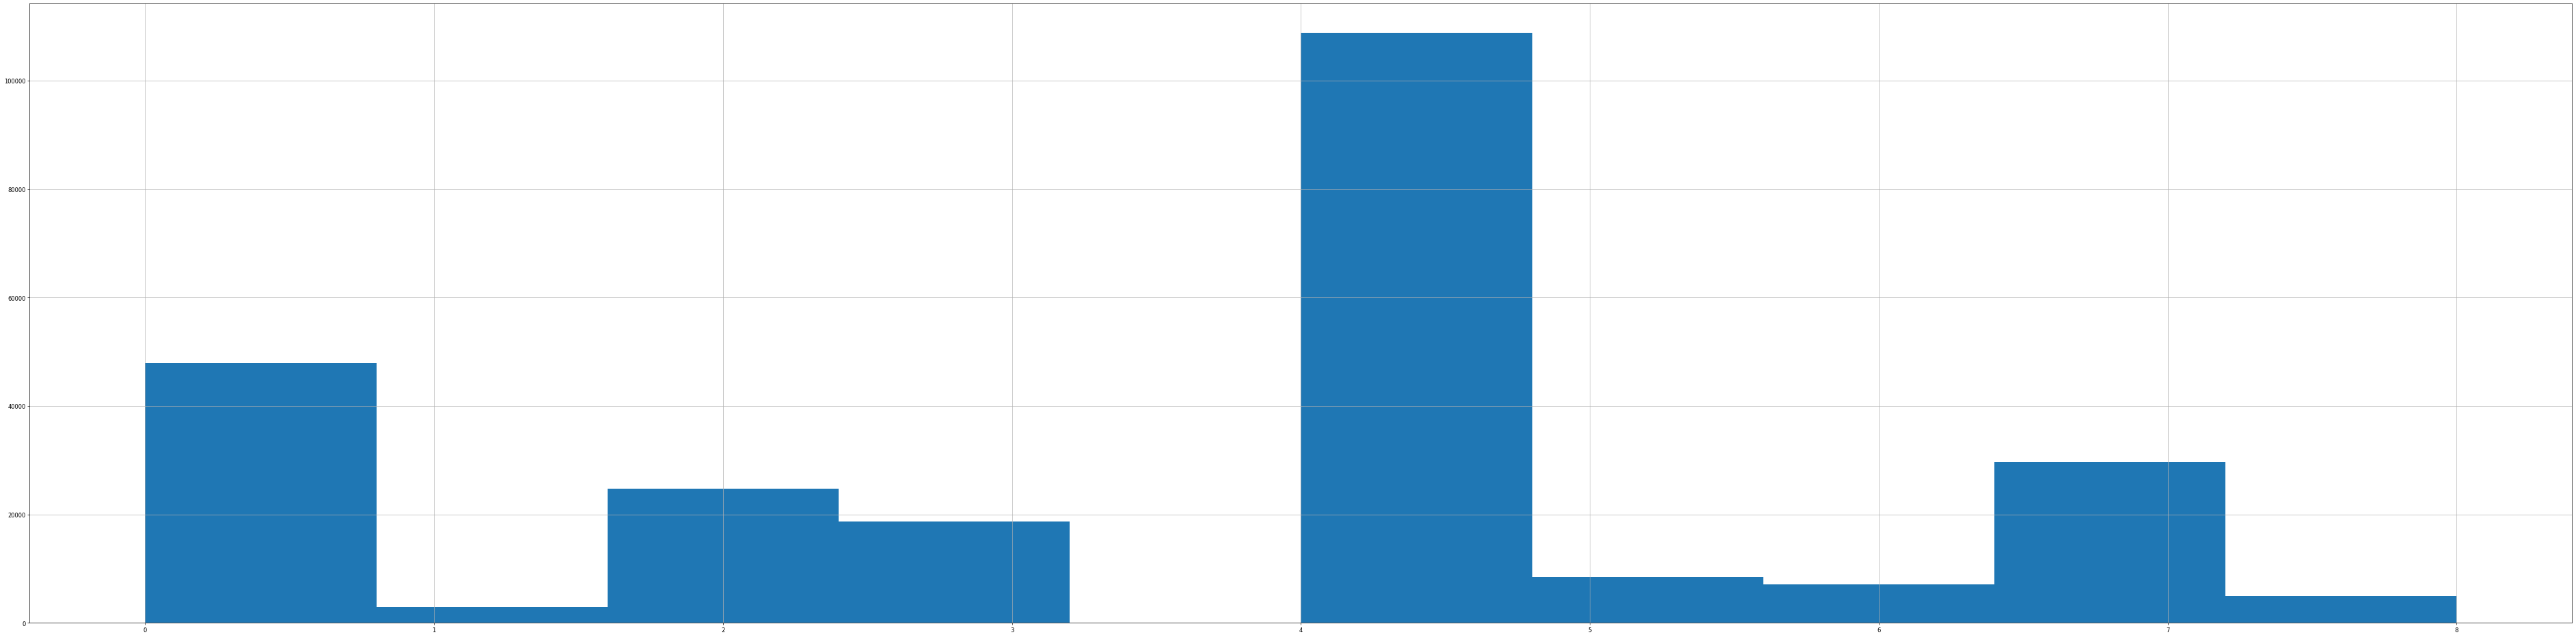

In [ ]:
plt.figure(figsize=(80, 20), dpi=60)
new_DataFrame['Category'].hist()

Actual splitting into a test set, training set (and validation set?)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

Creating a Decision tree classifier object

In [ ]:
clf = DecisionTreeClassifier(criterion="gini",max_depth=10)

Now I train the decision tree classifier

In [ ]:
clf = clf.fit(X_train,y_train)

Now I test the model on the test set held out in the beginning

In [ ]:
y_pred = clf.predict(X_test)

Now I measure model accuracy which means how often the classifier is correct

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100,str("%"))
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 46.0248676273017 %
              precision    recall  f1-score   support

           0       0.29      0.18      0.22     14434
           1       0.07      0.00      0.00       879
           2       0.29      0.17      0.21      7364
           3       0.20      0.01      0.03      5602
           4       0.51      0.93      0.66     32421
           5       0.08      0.00      0.00      2549
           6       0.06      0.00      0.00      2169
           7       0.24      0.10      0.14      9004
           8       0.11      0.00      0.00      1500

    accuracy                           0.46     75922
   macro avg       0.21      0.15      0.14     75922
weighted avg       0.35      0.46      0.36     75922



In [ ]:
#con kfold e usando la metrica di accuracy
kfold = model_selection.KFold(n_splits=12, random_state=7, shuffle=True)
scoring_0 = 'accuracy' #accuracy
results_0 = model_selection.cross_val_score(LogisticRegression(solver='liblinear'), x, y, cv=kfold, scoring=scoring_0)
print("accuracy: %.3f (%.3f)" % (results.mean(), results.std()))


accuracy: 0.407 (0.003)
